# Waveform Database Demo

This notebook showcases a few sample queries running against waveform and general (parameter) time series data in the High Frequency Data (HFD) schema populated by the interoperability production included in this repository. All queries are using standard ANSI SQL syntax against InterSystems IRIS.

Please note the identifiers and time ranges used here may need to be adjusted depending on the data you loaded.

### Setting up

Importing libraries and connecting to the main IRIS instance.

In [34]:
import iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [35]:
# connect to IRIS

connection_string = "iris:1972/USER"
username = "_SYSTEM"
password = "SYS" 
connection = iris.connect(connection_string, username, password)
print('Connection established')
cursor = connection.cursor()

Connection established


### Using SQL on High-Frequency Data

Data is organized in series, which group data from different (OBX segments in) messages that correspond to the same patient-device combination. 
Series metadata therefore includes metadata about the patient, device, and other relevant fields from the contributing HL7 messages that can easily be joined to other information sources, such as a device library or, obviously, the EMR.

In [63]:
cursor.execute('''
    SELECT TOP 100 
        s.SeriesID, s.ObservationStart, 
        (SELECT COUNT(*) FROM HFD_Data.SeriesValue v WHERE s.Epoch = v.Epoch AND s.SeriesID = v.SeriesID) AS SeriesValues, 
        d.* 
    FROM HFD_Data.SeriesMeta s JOIN HFD_Data.DeviceInfo d 
            ON s.DeviceType = d.DeviceType
''')
pd.DataFrame(cursor.fetchall(), columns = [t[0] for t in cursor.description])

,SeriesID,ObservationStart,SeriesValues,DeviceType,Device,Manufacturer,Category,SubCategory
0,1,2024-07-31 11:12:37.884,730,DragerMedibus_5.3.23.8_Atlan_Dräger,Drager Atlan,Drager,Anesthesia,Anesthesia/Ventilator Machine
1,2,2024-07-31 11:12:37.903,37038,SpectrumB_5.2.0.6_Quantum Workstation_Spectrum...,The Quantum Workstation,Quantum,Perfusion/Bypass,Perfusion Controller
2,3,2024-07-31 11:12:37.903,1,SpectrumB_5.2.0.6_Quantum Workstation_Spectrum...,The Quantum Workstation,Quantum,Perfusion/Bypass,Perfusion Controller
3,4,2024-07-31 11:12:37.890,519,MasimoD_5.3.4.6_Root_Masimo,Masimo Root Platform,Masimo,Monitor,Patient Monitoring and Connectivity Platform
4,5,2024-07-31 11:12:37.918,510,DragerMedibus_5.2.20.8_Apollo [MEDIBUS.X]_Dräger,Drager Apollo,Drager,Anesthesia,Anesthesia/Ventilator Machine
...,...,...,...,...,...,...,...,...
95,302,2024-07-31 11:12:37.990,121,DatexA_5.3.20.34_CARESCAPE B650_Datex,GE Carescape B650,GE,Monitor,Patient Monitoring System
96,303,2024-07-31 11:12:37.990,121,DatexA_5.3.20.34_CARESCAPE B650_Datex,GE Carescape B650,GE,Monitor,Patient Monitoring System
97,304,2024-07-31 11:12:37.990,121,DatexA_5.3.20.34_CARESCAPE B650_Datex,GE Carescape B650,GE,Monitor,Patient Monitoring System
98,305,2024-07-31 11:12:37.990,252,DatexA_5.3.20.34_CARESCAPE B650_Datex,GE Carescape B650,GE,Monitor,Patient Monitoring System


In [61]:
# count number of series per device category
cursor.execute('''
    SELECT Category, Manufacturer, COUNT(DISTINCT CollectorID) as Collectors, COUNT(*) AS Series
    FROM HFD_Data.SeriesMeta s JOIN HFD_Data.DeviceInfo d 
            ON s.DeviceType = d.DeviceType
    GROUP BY %EXACT(Category), %EXACT(Manufacturer)
''')
pd.DataFrame(cursor.fetchall(), columns = [t[0] for t in cursor.description])

,Category,Manufacturer,Collectors,Series
0,Monitor,GE,32,1921
1,Monitor,idmed,11,125
2,Monitor,Masimo,2,119
3,Anesthesia,Drager,34,1854
4,Perfusion/Bypass,Quantum,1,124


### What does a Blood Pressure series look like?

Note: series ID may differ or be missing depending on dataset loaded

In [64]:
# data from 17.06 dataset
cursor.execute('''SELECT * FROM HFD_Data.SeriesMeta WHERE PatientID = 8007637 AND ObservationID = 501''')
meta = cursor.fetchone()
for i in cursor.description:
    print(i[0], ': ', meta[i[0]])
    
epoch = meta['Epoch']
seriesID = meta['SeriesID']

ID :  202406||10359
CollectorID :  MGHMGHB08_B0858A
DeviceType :  None
Epoch :  202406
ObservationID :  501
ObservationStart :  2024-06-17 10:48:35
ObservationSubID :  BP1
PatientID :  8007637
SeriesID :  10359


In [77]:
sql = '''
    SELECT 
        ID, BucketID, Epoch, SeriesID, chunk, pos, TO_CHAR(CAST(ts AS TIME),'HH:MI:SS') as ts, value
    FROM HFD_Data.SeriesValue 
    WHERE Epoch = ? AND SeriesID = ?
        AND ts BETWEEN '2024-06-17 10:50:00' AND '2024-06-17 11:10:00'
'''

cursor.execute(sql, [epoch, seriesID])
df = pd.DataFrame(cursor.fetchall(), columns = [t[0] for t in cursor.description])
print("fetched", len(df), "rows")

fetched 241 rows


In [75]:
df

,ID,BucketID,Epoch,SeriesID,chunk,pos,ts,value
0,202406||2024061||10359||1||100,2024061,202406,10359,1,100,10:56:45,9800
1,202406||2024061||10359||1||101,2024061,202406,10359,1,101,10:56:55,9600
2,202406||2024061||10359||1||102,2024061,202406,10359,1,102,10:57:00,9800
3,202406||2024061||10359||1||103,2024061,202406,10359,1,103,10:57:10,9800
4,202406||2024061||10359||1||104,2024061,202406,10359,1,104,10:57:05,9800
...,...,...,...,...,...,...,...,...
236,202406||2024061||10359||1||95,2024061,202406,10359,1,95,10:56:25,9800
237,202406||2024061||10359||1||96,2024061,202406,10359,1,96,10:56:30,9700
238,202406||2024061||10359||1||97,2024061,202406,10359,1,97,10:56:40,9600
239,202406||2024061||10359||1||98,2024061,202406,10359,1,98,10:56:35,9500


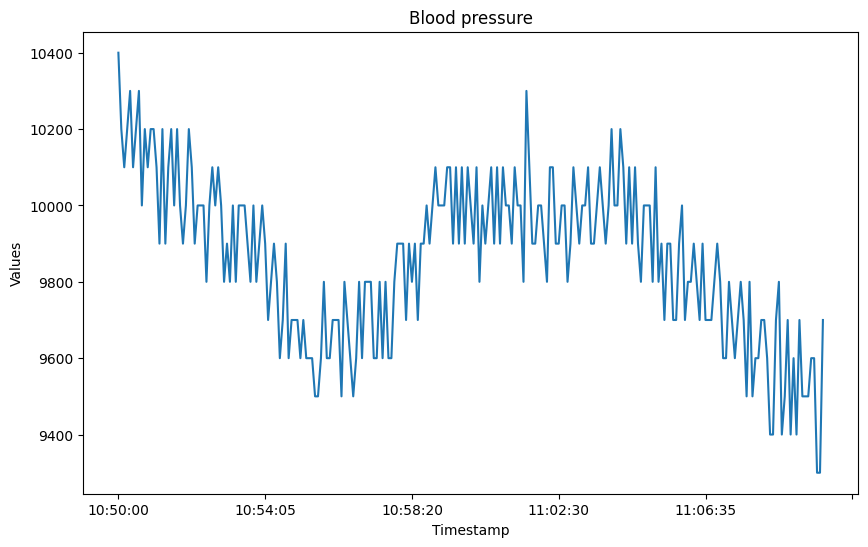

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(df["ts"], df["value"])

plt.title('Blood pressure')
plt.xlabel('Timestamp')
plt.ylabel('Values')

plt.gca().xaxis.set_major_locator(plt.AutoLocator())

Let's add a few more series from related sensors to the chart

In [79]:
# let's add a few more series to the chart
cursor.execute('''
    SELECT 
        SeriesID,
        CollectorID, 
        ObservationID, 
        ObservationSubID,
        PatientID
    FROM 
        HFD_Data.SeriesMeta 
    WHERE 
        PatientID = 8007637 AND ObservationSubID LIKE 'BP%'
''')
series = pd.DataFrame(cursor.fetchall(), columns = [t[0] for t in cursor.description])
series

,SeriesID,CollectorID,ObservationID,ObservationSubID,PatientID
0,10358,MGHMGHB08_B0858A,2664,BP1,8007637
1,10359,MGHMGHB08_B0858A,501,BP1,8007637
2,10360,MGHMGHB08_B0858A,502,BP1,8007637
3,10361,MGHMGHB08_B0858A,503,BP1,8007637
4,10362,MGHMGHB08_B0858A,1242,BP1,8007637
5,10363,MGHMGHB08_B0858A,2664,BP2,8007637
6,10364,MGHMGHB08_B0858A,504,BP2,8007637
7,10365,MGHMGHB08_B0858A,505,BP2,8007637
8,10366,MGHMGHB08_B0858A,506,BP2,8007637
9,10367,MGHMGHB08_B0858A,2664,BP3,8007637


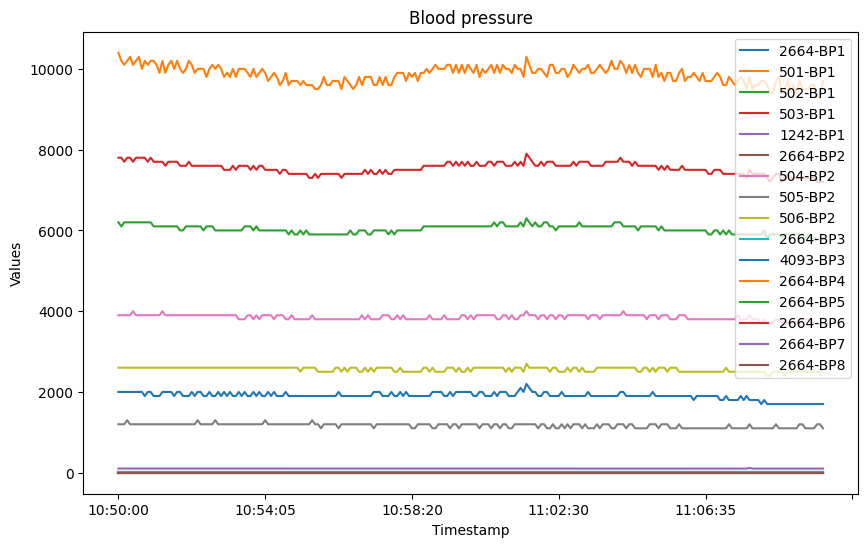

In [80]:
plt.figure(figsize=(10, 6))

for s in range(len(series)):
    cursor.execute(sql, [epoch, int(series['SeriesID'][s])])
    df = pd.DataFrame(cursor.fetchall(), columns = [t[0] for t in cursor.description])
    plt.plot(df["ts"], df["value"], label=(series['ObservationID'][s]+'-'+series['ObservationSubID'][s]))

plt.title('Blood pressure')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()

plt.gca().xaxis.set_major_locator(plt.AutoLocator())

### More complicated queries